### <center>TP 8 - Réduction de la dimension</center>

# <center> Détection d'anomalie: étude de cas de détection de fraude à la carte bancaire</center>

# Partie I : Analyse exploratoire des données

## Imporatations des librairies

In [92]:
# OS 
import os
import sys 

# WARNINGS
import warnings
warnings.filterwarnings('ignore')

# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew
import scipy as scp

# MATPLOTLIB
import matplotlib as mpl
import matplotlib.pyplot as plt
# params = {'axes.labelsize': 6, #12,
#          'font.size': 6, #12,
#          'legend.fontsize': 6, #12,
#           'xtick.labelsize': 6, #10,
#          'ytick.labelsize': 6, #10,
#           'text.usetex': True,
#          'figure.figsize': (15, 8)
#}
# plt.rcParams.update(params)
%matplotlib inline 

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABRON
import seaborn as sns
# sns.set_context("poster")
# sns.set_style("ticks")

# SCIKIT-LEARN: PRE-PROCESSING
import sklearn as sk
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # standardisation des variables numériques
from sklearn.preprocessing import MinMaxScaler # normalisation des variables numériques
from sklearn.preprocessing import RobustScaler # normalisation des variables numériques
from sklearn.impute import SimpleImputer # imputation des valeurs manquantes
from sklearn.impute import KNNImputer # imputation des valeurs manquantes par la méthode KNN
from sklearn.feature_selection  import SelectKBest # sélectionner 
from sklearn. preprocessing import PolynomialFeatures 

# MODELES PREDICTIFS

## REGRESSION
from sklearn.linear_model import LogisticRegression # régréssion logistique

## SVM 
from sklearn.svm import LinearSVC # machines à vecteurs de support (linéaire)
from sklearn.svm import SVC # machines à vecteurs de support (non-linéaire)

## SGD
from sklearn.linear_model import SGDClassifier #  classifieurs (SVM, régression logistique, etc.) avec un algorithme SGD

## ARBRES, FORETS, APRRENTISSAGE D'ENSEMBLE
from sklearn.tree import DecisionTreeClassifier # arbres classification
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier 

## KNN
from sklearn.neighbors import KNeighborsClassifier # KPP voisins

# REDUCTION DE LA DIMENSION 
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, LocallyLinearEmbedding, Isomap, TSNE


# VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # séparation des données en train et test set
from sklearn.model_selection import cross_val_score # validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # courbe de validation: visulaisr les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # tester plusieurs hyperparamètres
from sklearn.model_selection import RandomizedSearchCV # tester arbitrairement plusieurs hyperparamètres
from sklearn.model_selection import learning_curve # courbe d'apprentissage: visualisation les scores du train et du validation sets en fonction des quanitiés des données
 
## EVALUATION: METRIQUES DE CLASSIFICATION
from sklearn.metrics import accuracy_score # exactitude (accuracy)
from sklearn.metrics import f1_score # F1-score
from sklearn.metrics import confusion_matrix # matrice de confusion
# from sklearn.metrics import plot_confusion_matrix # graphique de la matrice de confusion
from sklearn.metrics import classification_report # rapport pour le modèle de classification
from sklearn.metrics import mean_squared_error

## EVALUATION: COURBE ROC
from sklearn.metrics import auc # aire sous la courbe 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import precision_recall_curve #
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import average_precision_score


# PIPELINE
from sklearn.pipeline import make_pipeline

# TRANSFORMATEUR COMPOSITE (PRE-PROCESSOR + MODELE)
from sklearn.compose import make_column_transformer



In [93]:
import platform, psutil
print('System         :', platform.system())
print('Python Version :', platform.python_version())
print('Version tuple  :', platform.python_version_tuple())
print('Compiler       :', platform.python_compiler())
print('RAM            :', str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB")
print('Build          :', platform.python_build())

System         : Darwin
Python Version : 3.11.8
Version tuple  : ('3', '11', '8')
Compiler       : Clang 16.0.6 
RAM            : 64 GB
Build          : ('main', 'Feb 16 2024 20:49:36')


In [94]:
print('Python     : {}'.format(sys.version))
print('Numpy      : {}'.format(np.__version__))
print('Pandas     : {}'.format(pd.__version__))
print('Matplotlib : {}'.format(mpl.__version__))
print('Seaborn    : {}'.format(sns.__version__))
print('Scipy      : {}'.format(scp.__version__))
print("Sklearn    : {}".format(sk.__version__))

Python     : 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:49:36) [Clang 16.0.6 ]
Numpy      : 1.24.3
Pandas     : 2.2.2
Matplotlib : 3.8.0
Seaborn    : 0.12.2
Scipy      : 1.11.3
Sklearn    : 1.3.0


# Partie I: Analyse exploratoire des données

## 1. Chargement et description des données credit card

In [95]:
data = pd.read_csv('./data/creditcard.csv')
df = data.copy()

In [98]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [99]:
# Dimensions
df.shape

(284807, 31)

L'ensemble de données contient $284,807$ lignes et $31$ colonnes.

In [100]:
# Vérifions les colonnes de l'ensemble de données
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

L'ensemble de données contient $31$ colonnes, seules $3$ colonnes ont du sens, à savoir le temps, le montant et la classe (fraude ou non fraude). Le reste des $28$ colonnes a été transformé en utilisant la réduction de dimensionnalité PCA afin de protéger les identités des utilisateurs. Toutes les colonnes transformées sont nommées de $V_1$ à $V_{28}$.


In [101]:
# Quelques informations sur les features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [102]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [103]:
# Vérifions si nous avons des valeurs manquantes dans notre ensemble de données
# df.isnull().sum()
df.isnull().values.any()

False

Nous n'avons aucune valeur manquante dans notre ensemble de données.

## 2. Analyse univariée et bivariée des variables

###  2.1. Distribution de la cible: "Class"

Notre colonne cible est 'Class' contient deux classes qui sont étiquetées fraude comme $1$ et non une fraude étiquetée comme $0$.

In [104]:
print("Nombre de transactions frauduleuses:", df['Class'].sum())

Nombre de transactions frauduleuses: 492


In [105]:
df.Class.value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Dans cet ensemble de données, il n'y a que $0.172\%$ (total de $492$) de transactions frauduleuses et $99.82\%$ (total de 284,315 ) de transactions légitimes.

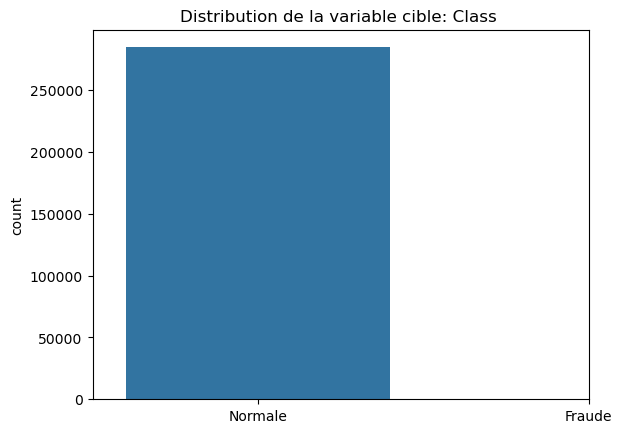

In [13]:
# Distribution de la cible
sns.countplot(df['Class'])
plt.title('Distribution de la variable cible: Class ')
plt.xticks(range(2),['Normale','Fraude'])
plt.show()

Comme les données sont fortement déséquilibrées, une classe ne représentant que 0,17 %, nous considérons qu'il s'agit d'un problème de détection d'anomalie.

### 2.2. Distributions des variables

In [106]:
# Distribution des variables
features = df.columns.values[1:30]
def plot_feature_distribution(features):
    i=0
    sns.set_style('whitegrid')

    fig=plt.figure()
    ax=plt.subplots(5,6,figsize=(22,18))

    for feature in features:
        i+=1
        plt.subplot(5,6,i)
        sns.distplot(df[feature],hist=False)
        plt.xlabel(str(feature),)
        sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

<Figure size 640x480 with 0 Axes>

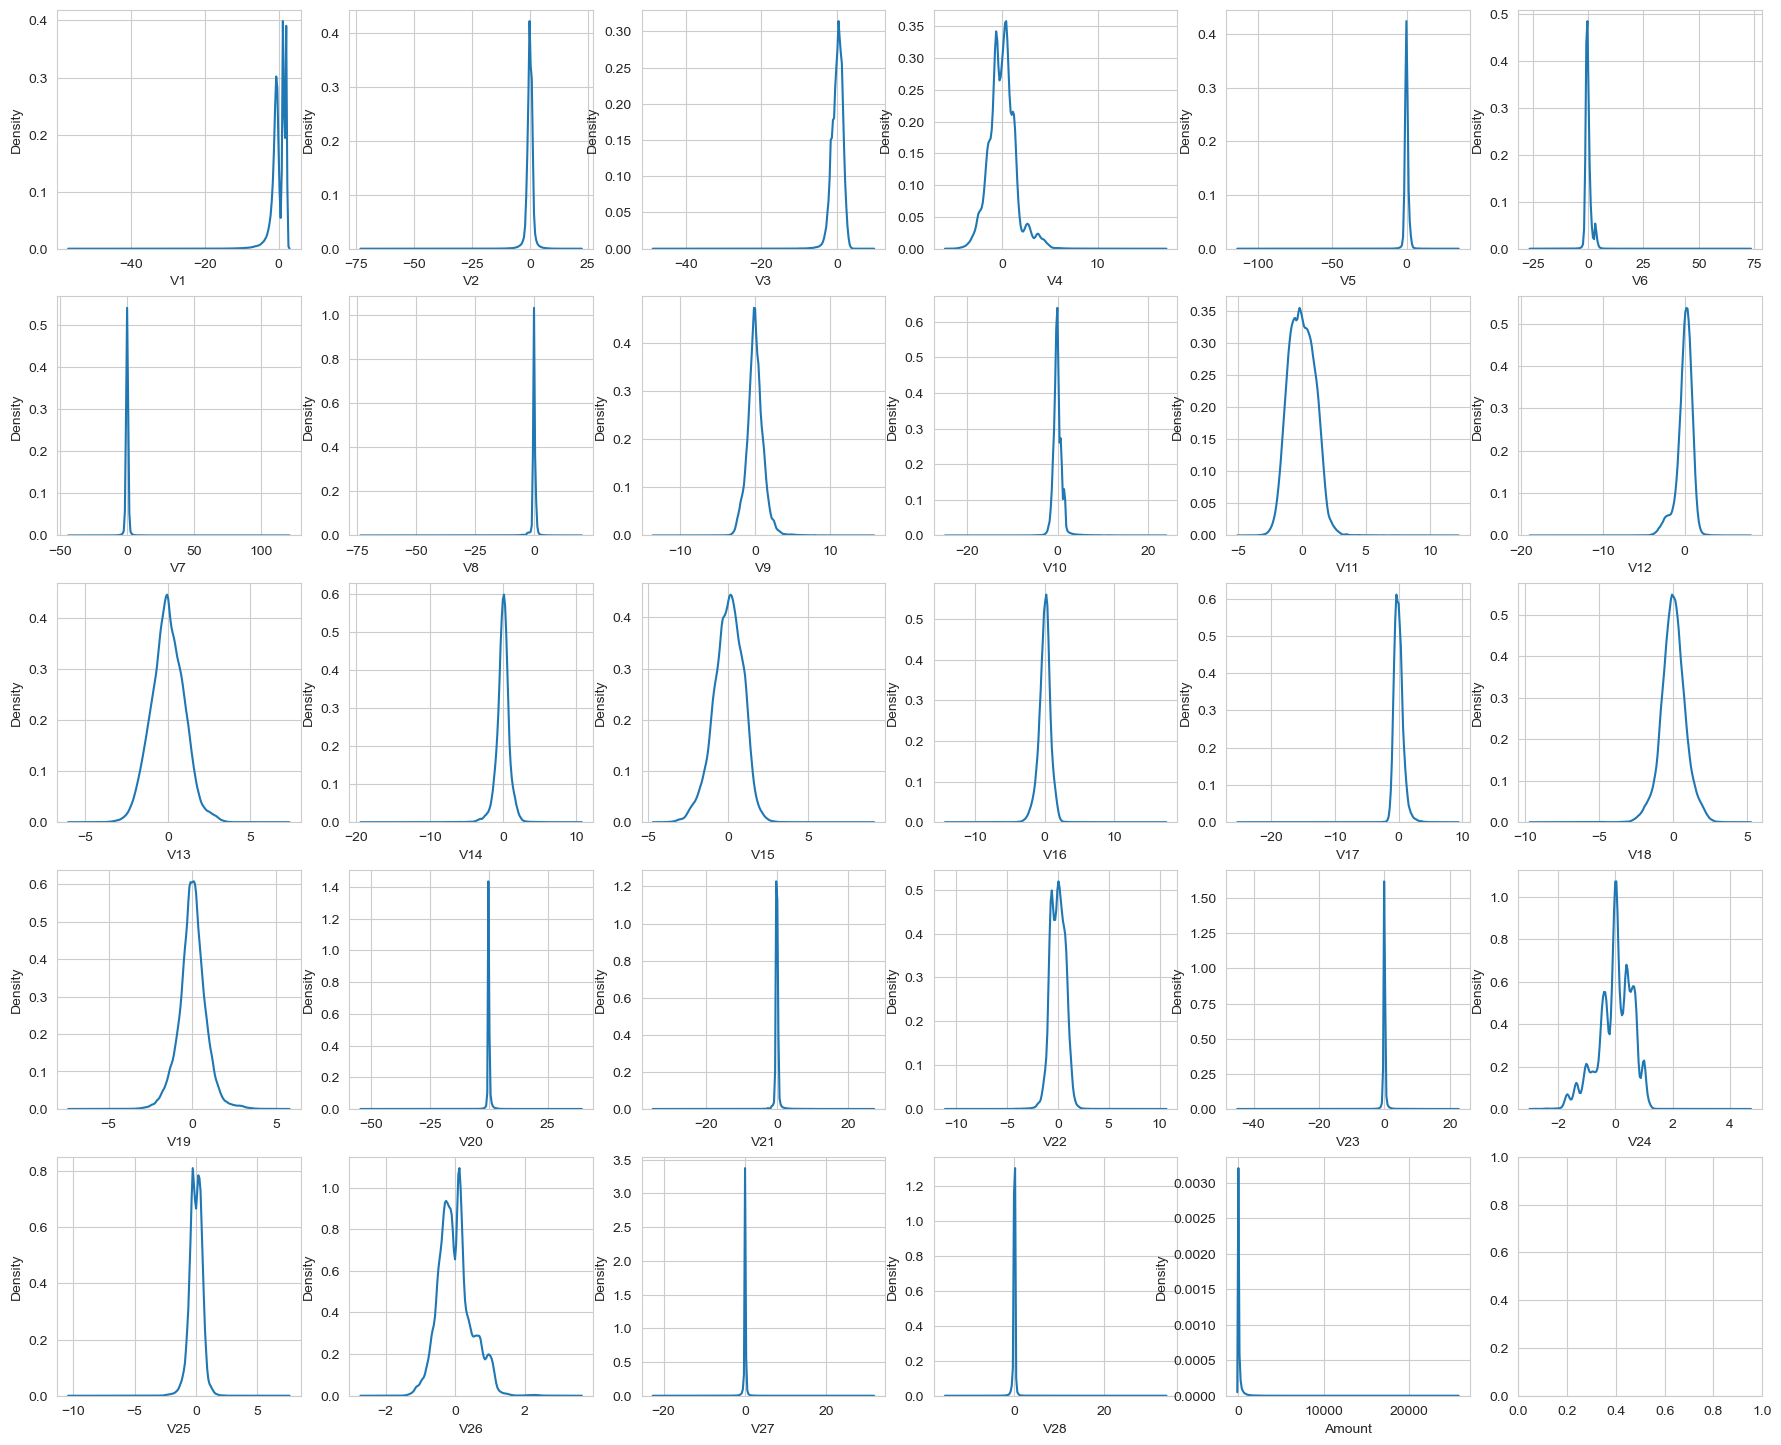

In [107]:
plot_feature_distribution(features)
plt.show()

### 2.3. Distribution variables: "Time" et "Amount"

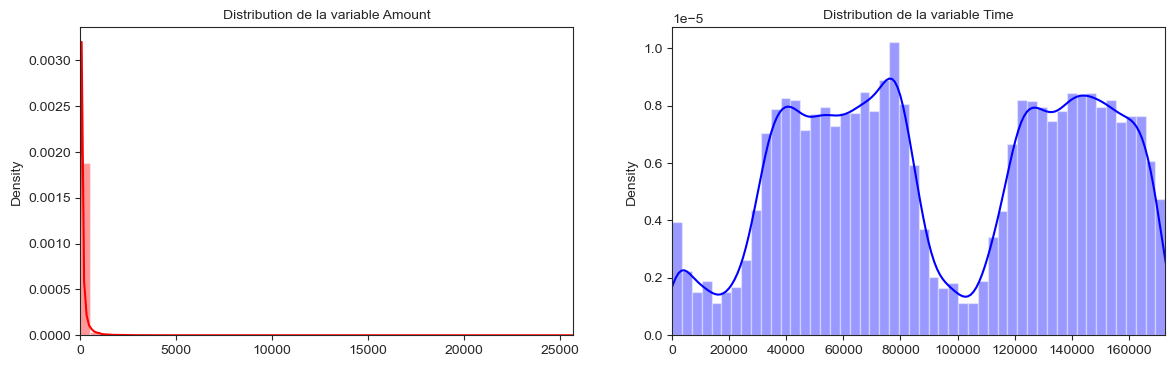

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution de la variable Amount', fontsize=10)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution de la variable Time', fontsize=10)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

<Axes: >

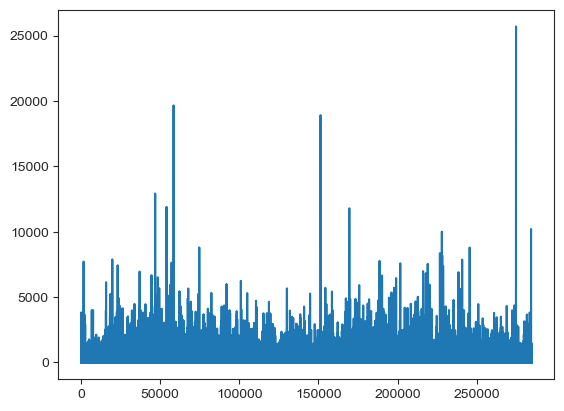

In [112]:
df['Amount'].plot()

Puisque seules les variables "Temps" et "Montant" sont facilement interprétables, nous pouvons utiliser certaines visualisations pour voir leurs impacts sur la variable cible (la fraude). Premièrement, les fraudes se produisent-elles davantage sur les petites ou les grosses transactions?

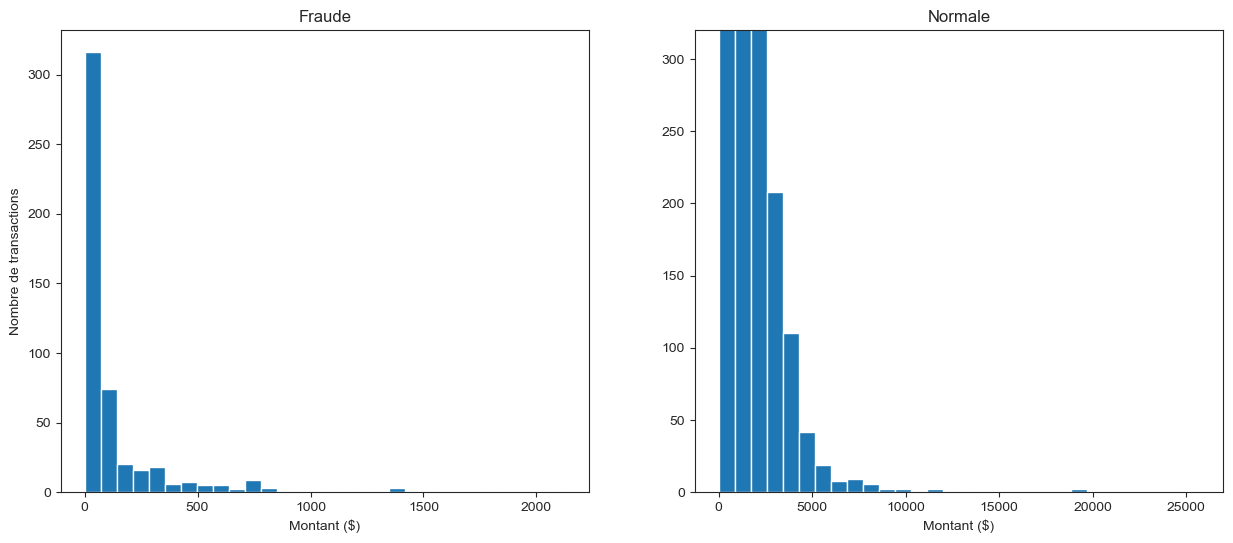

In [113]:
df_fraud = df[df['Class'] == 1]
df_normal = df[df['Class'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
bins = 30

ax1.hist(df_fraud['Amount'], bins=bins)
ax2.hist(df_normal['Amount'], bins=bins)

ax1.set_title('Fraude')
ax2.set_title('Normale')

ax1.set_xlabel('Montant (\$)')
ax2.set_xlabel('Montant (\$)')
ax1.set_ylabel('Nombre de transactions')

ax2.set_ylim(0, 320)
plt.show()

Le nombre de transactions est très différent car il y a beaucoup plus de transactions normales que de fraudes. Nous pouvons simplement voir les différences entre les graphiques. En les regardant, nous pouvons voir que la plupart des fraudes se produisent sur de petites transactions (~500$).

In [18]:
# Changement de la variable Time 
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24)
df_fraud = df[df['Class'] == 1]
df_normal = df[df['Class'] == 0]

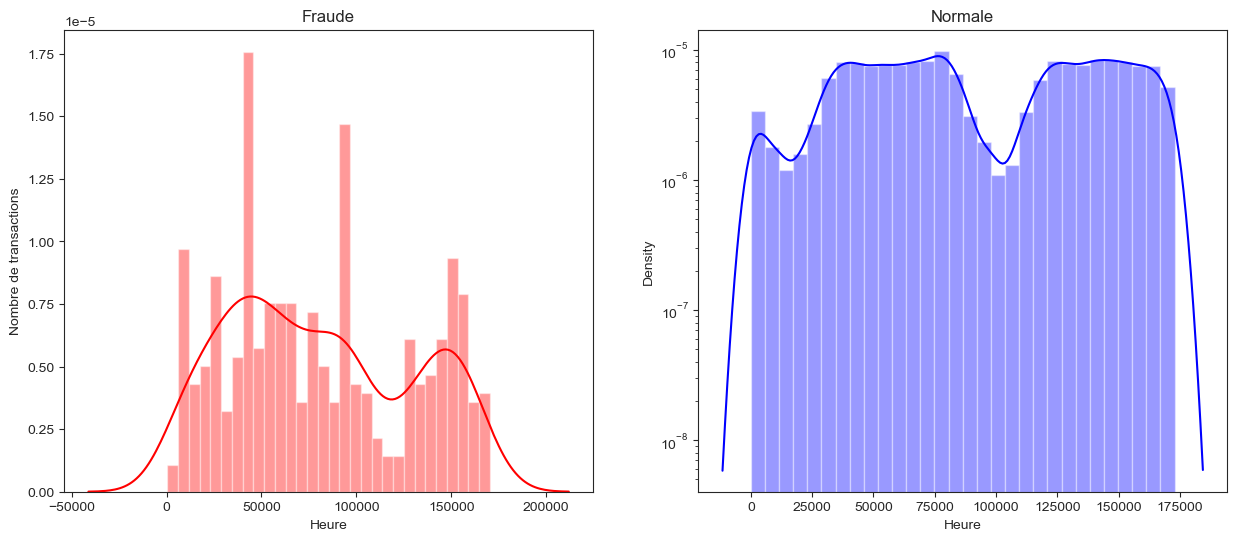

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
bins = 30

# ax1.hist(df_fraud['Time'], bins=bins)
sns.distplot(df_fraud['Time'], ax=ax1, color='r', bins=bins)
sns.distplot(df_normal['Time'], ax=ax2, color='b', bins=bins)

ax1.set_title('Fraude')
ax2.set_title('Normale')

ax1.set_xlabel('Heure')
ax2.set_xlabel('Heure')
ax1.set_ylabel('Nombre de transactions')

ax2.set_yscale('log')
plt.show()

La variable "Time" peut être très instructive, sur les graphiques ci-dessus nous pouvons voir que la plupart des fraudes se produisent à ~2(matin) et ~12h(midi).

### 2.4. Analyse bivariée

### Matrice de corrélation

Nous pouvons observer si les variables de l'ensemble de données sont corrélées les unes aux autres en utilisant le diagramme de carte thermique implémenté dans la bibliothèque seaborn.

In [115]:
correlation_matrix = df.corr()

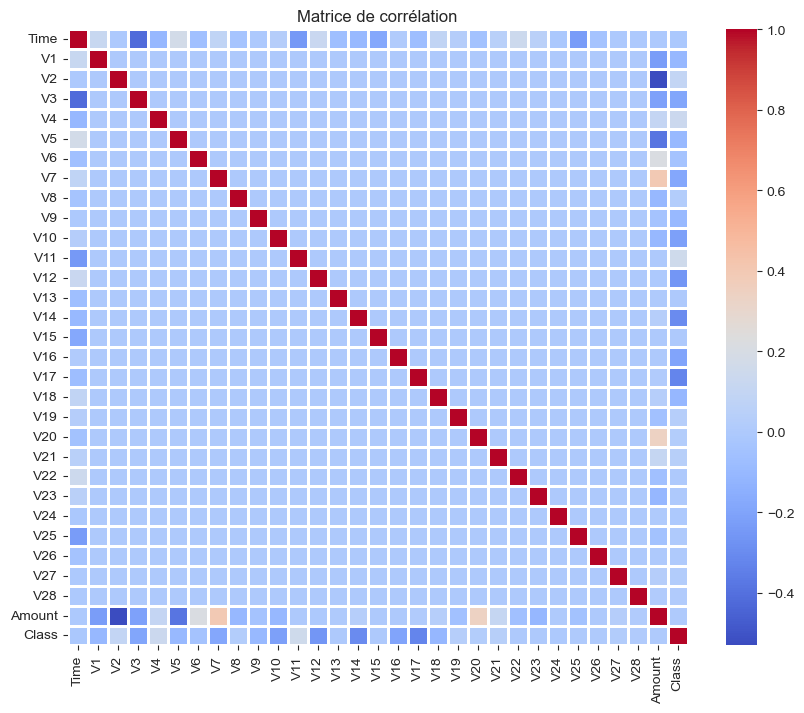

In [116]:
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, cmap = "coolwarm", linewidth = 2, linecolor = "white")  # 'BuPu'
plt.title("Matrice de corrélation")
# f, ax = plt.subplots(1, 1, figsize=(50, 40))
# sns.heatmap(correlation_matrix, cmap='coolwarm_r',annot=False, annot_kws={'size':20})
# ax.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=24)

plt.show()

In [22]:
# plt.figure(figsize=(12,5*4))
# gs = gridspec.GridSpec(5, 1)
# for i, cn in enumerate(df.columns[3:4]):
    # ax = plt.subplot(i)
    # sns.distplot(df[cn][df.Class == 1], bins=30, label="fraud")
    # sns.distplot(df[cn][df.Class == 0], bins=30)
    # ax.set_xlabel('b')
    # ax.set_title('Histogramme de la varaible: ' + str(cn))
#plt.show();

<Figure size 640x480 with 0 Axes>

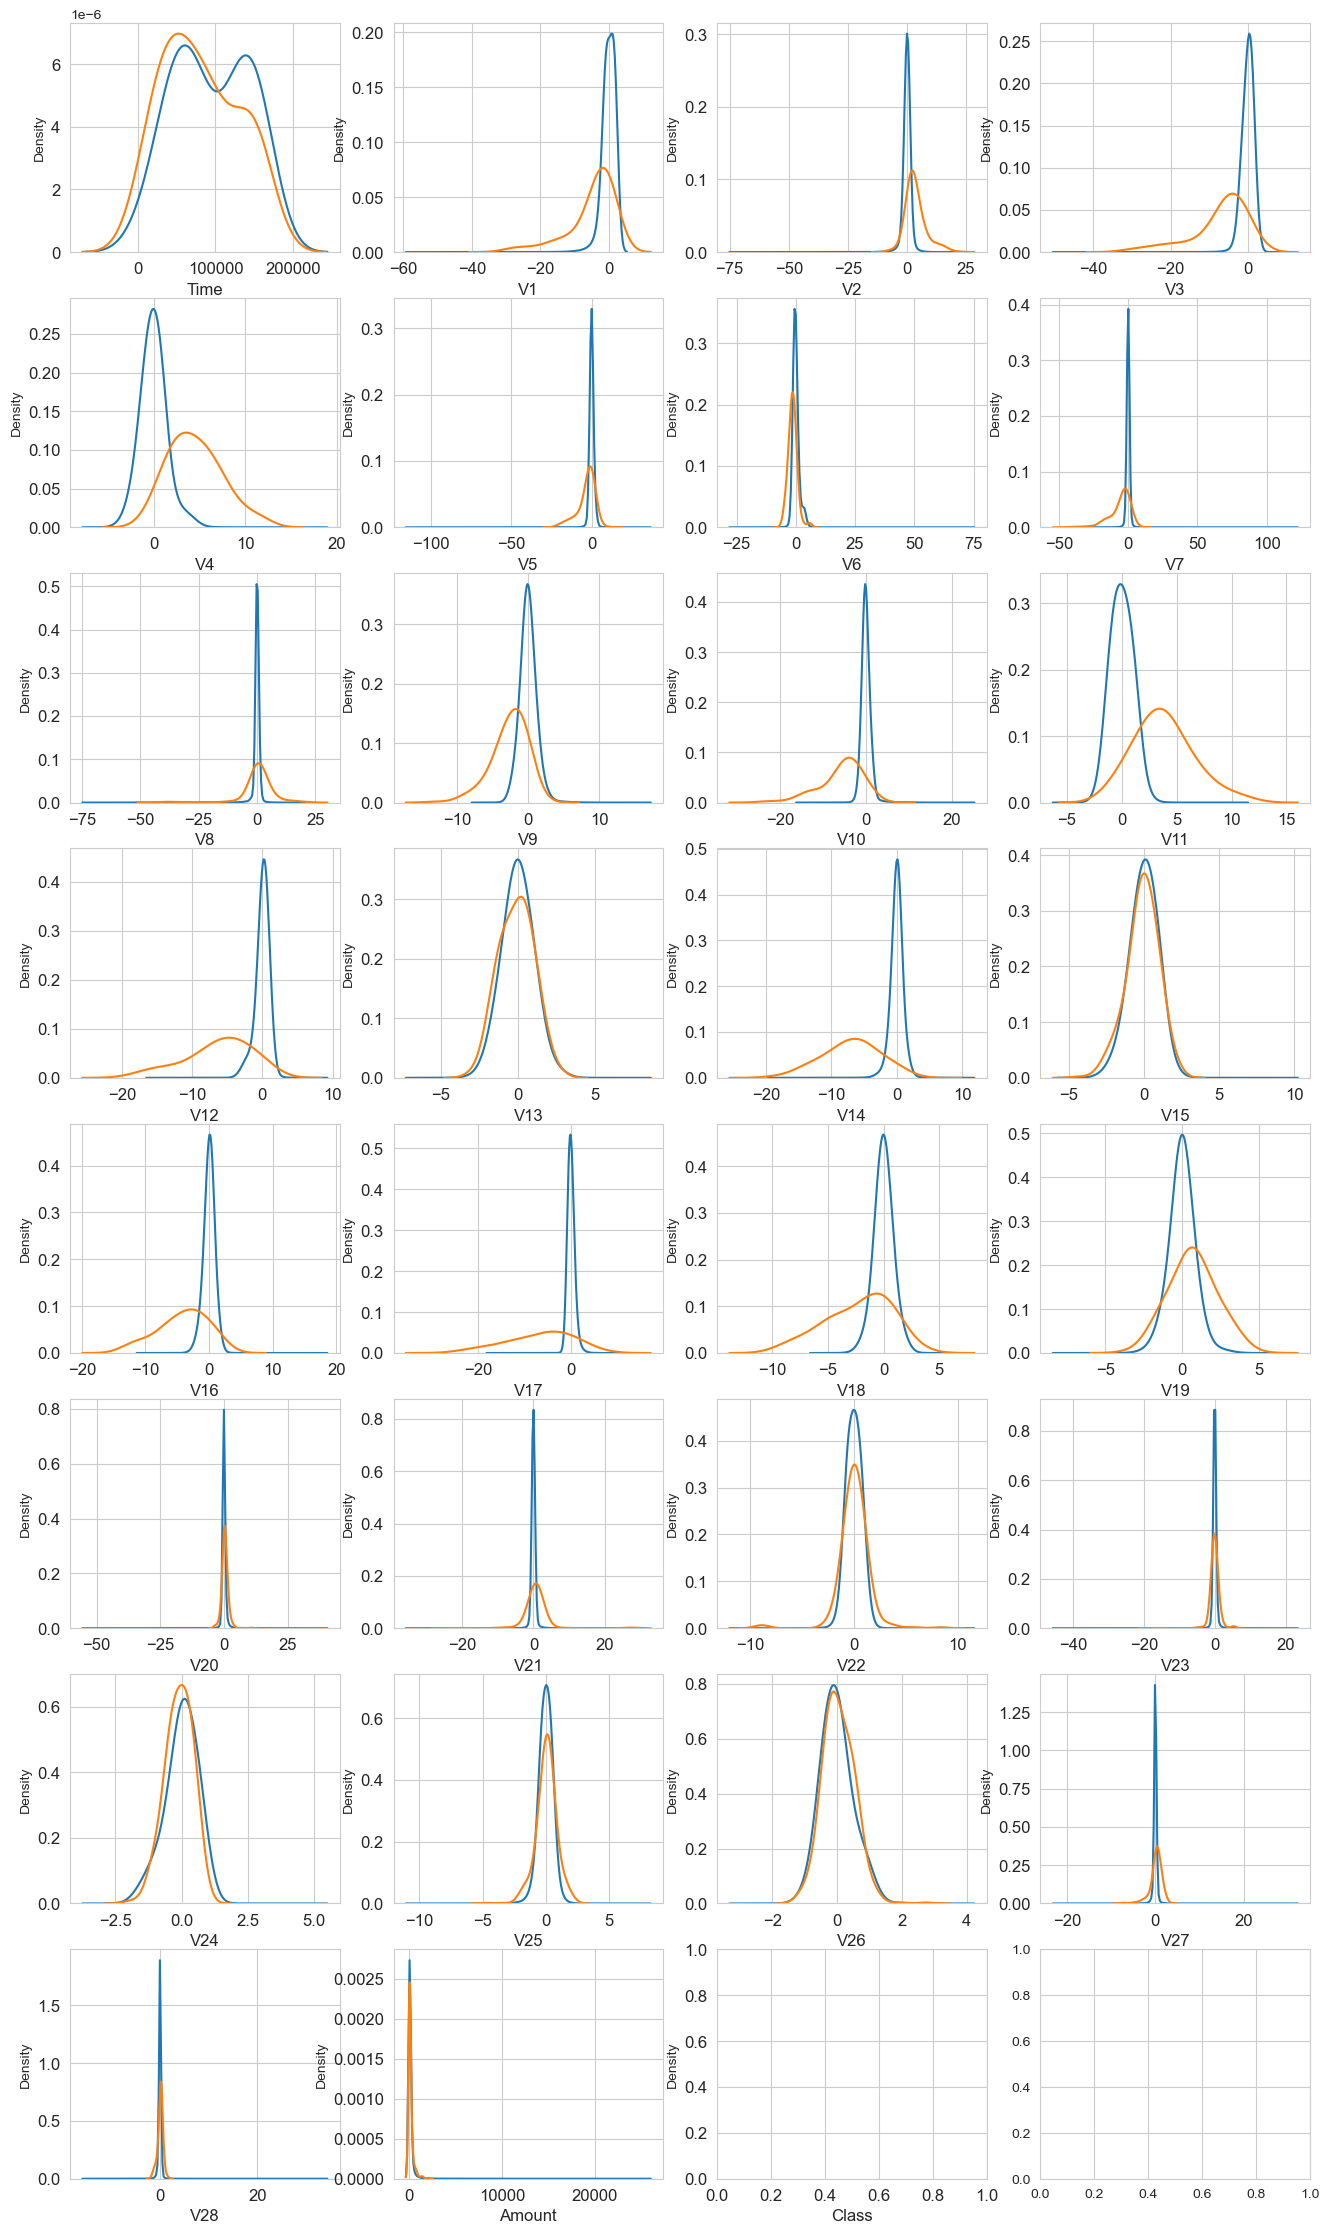

In [117]:
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# Partie II : Pré-traitement de données

## 1. Standariser les variables : "Time" et "Amount"

In [24]:
def preprocessing(df):
    X = df.drop('Class', axis=1)
    X = df.drop('Time', axis=1)
    X = df.drop('Amount', axis=1)
    y = df['Class']
    features = X.columns
    scaler = StandardScaler()
    X.loc[:, features] = scaler.fit_transform(X[features])
    return X, y

##  2. Séparation données de train et test 

In [25]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

In [26]:
df_train.shape, df_test.shape

((227845, 31), (56962, 31))

In [27]:
df_train['Class'].value_counts()

Class
0    227454
1       391
Name: count, dtype: int64

In [28]:
df_test['Class'].value_counts()

Class
0    56861
1      101
Name: count, dtype: int64

In [29]:
X_train, y_train = preprocessing(df_train)

In [30]:
X_test, y_test = preprocessing(df_test)

# Partie III : Modélisation + Évaluation

## 1. Métrique d'évaluation

Les classificateurs binaires sont couramment évalués à l'aide de mesures de performance telles que la sensibilité et la spécificité, et les performances sont fréquemment illustrées par des diagrammes ROC (Receiver Operating Characteristics). D'autres mesures, telles que la valeur prédictive positive (VPP) et les diagrammes Précision/Rappel (PRC) associés, sont moins fréquemment utilisées. 
De nombreuses études bioinformatiques développent et évaluent des classificateurs qui doivent être appliqués à des ensembles de données fortement déséquilibrés dans lesquels le nombre de négatifs l'emporte largement sur le nombre de positifs. Bien que les diagrammes ROC soient visuellement attrayants et fournissent une vue d'ensemble des performances d'un classificateur sur une large gamme de spécificités, on peut se demander si les diagrammes ROC ne sont pas faussés lorsqu'ils sont appliqués à des scénarios de classification déséquilibrée. Nous montrons ici que l'interprétabilité visuelle des diagrammes ROC dans le contexte d'ensembles de données déséquilibrés peut être trompeuse en ce qui concerne les conclusions sur la fiabilité des performances de classification, en raison d'une interprétation intuitive mais erronée de la spécificité. En revanche, les diagrammes PRC peuvent fournir à l'observateur une prédiction précise des performances de classification futures, car ils évaluent la fraction de vrais positifs parmi les prédictions positives. Nos résultats ont des implications potentielles pour l'interprétation d'un grand nombre d'études qui utilisent des diagrammes ROC sur des ensembles de données déséquilibrés.

Nous allons définir une fonction qui calcule le taux (score) d'anomalie de chaque transaction. Plus la transaction est anormale, plus il est probable qu'elle soit frauduleuse, en supposant que la fraude est rare et a une apparence quelque peu différente de la
la majorité des transactions, qui sont normales.

Les algorithmes de réduction de la dimension réduisent la dimension des données tout en essayant de minimiser l'erreur de reconstruction. . En d'autres termes, ces algorithmes essaient de capturer les informations les plus importantes des variables originales de manière à pouvoir reconstruire l'ensemble des ces variables d'origine à partir de l'ensemble réduit de variables possible.

Cependant, ces algorithmes de réduction de la dimension ne peuvent pas capturer toutes les informations des variables d'origine lorsqu'elles passent dans un espace de dimension inférieure ; par conséquent, il y aura une certaine erreur lorsque ces algorithmes reconstruiront l'ensemble des variables réduites pour revenir au nombre de dimensions d'origine.

Dans le contexte de notre ensemble de données sur les transactions par carte de crédit, les algorithmes auront la plus grande erreur de reconstruction sur les transactions les plus difficiles à modéliser, en d'autres termes, celles qui se produisent le moins souvent et qui sont les plus anormales. La fraude étant rare et vraisemblablement différente des transactions normales, les transactions frauduleuses devraient présenter la plus grande erreur de reconstruction. Définissons donc le score d'anomalie comme l'erreur de reconstruction. L'erreur de reconstruction pour chaque
transaction est la somme des différences au carré entre la matrice de caractéristiques d'origine et la matrice reconstruite à l'aide de l'algorithme de réduction de la dimension. Nous allons mettre à l'échelle la somme des différences au carré par la quantité maximale-minimale de la somme des différences au carré pour l'ensemble de l'ensemble de données, de sorte que toutes les erreurs de reconstruction soient comprises entre zéro et un.
Les transactions qui présentent la plus grande somme de différences au carré auront une erreur proche de un, tandis que celles qui présentent la plus petite somme de différences au carré auront une erreur proche de zéro.

l'algorithme de réduction de la dimension attribuera effectivement à chaque transaction un score d'anomalie entre zéro et un. Zéro est normal et un est anormal (et le plus susceptible d'être frauduleux).

Bien que nous n'utilisions pas les labels de fraude pour construire les solutions de détection de fraude non supervisées, nous utiliserons les labels pour évaluer les solutions non supervisées.  Les étiquettes nous aideront à comprendre à quel point ces solutions sont efficaces à attraper des modèles connus de fraude.


## Refs :

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432

https://stats.stackexchange.com/questions/502522/sklearn-average-precision-score-vs-auc

## 2. Fonctions d'évaluation

In [31]:
# Calculer l'erreur de reconstruction
def anomaly_scores(X_original, X_reduced):
    loss = np.sum((np.array(X_original) - np.array(X_reduced))**2, axis=1)
    loss = pd.Series(data=loss, index=X_original.index)
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss)) # loss entre 0. et 1.
    return loss

In [32]:
# Plot des résultats 
def plotResults(labels, anomaly_scores, returnPreds=False):

    df_preds = pd.concat([labels, anomaly_scores], axis=1)
    df_preds.columns = ['Labels', 'AnomalyScores']
    precision, recall, thresholds = precision_recall_curve(df_preds['Labels'], df_preds['AnomalyScores'])
    average_precision = average_precision_score(df_preds['Labels'], df_preds['AnomalyScores'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    
    # plt.plot(thresholds, precision[:-1], label='precision')
    # plt.plot(thresholds, recall[:-1], label='recall')
    # plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Courbe Precision-Recall : Moyenne de précision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(df_preds['Labels'], \
                                     df_preds['AnomalyScores'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='Courbe ROC')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC: \
    Aire sous la courbe ROC = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return df_preds

In [33]:
def scatterPlot(X, y):
    temp = pd.DataFrame(data=X.loc[:,0:1], index=X.index)
    temp = pd.concat((temp,y), axis=1, join="inner")
    temp.columns = ["PC1", "PC2", "Label"]
    sns.lmplot(x="PC1", y="PC2", hue="Label", \
               data=temp, fit_reg=False)
    ax = plt.gca()
    # ax.set_title("Spération des observation avec  "+algoName)

## 2. Composantes PCA égale au nombre original de la dimension

In [34]:
n_components = 30
random_state = 0

pca = PCA(n_components=n_components, random_state=random_state)

X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)

In [35]:
X_train_pca.shape

(227845, 30)

In [36]:
X_train_pca_inverse = pca.inverse_transform(X_train_pca)
X_train_pca_inverse = pd.DataFrame(data=X_train_pca_inverse, index=X_train.index)

In [37]:
X_train_pca_inverse.shape

(227845, 30)

In [38]:
anomalyScores = anomaly_scores(X_train, X_train_pca_inverse)
# anomalyScores.shape

In [39]:
anomalyScores.head()

68806     1.000000
40018     0.059717
250360    0.002710
234820    0.051664
10001     0.031697
dtype: float64

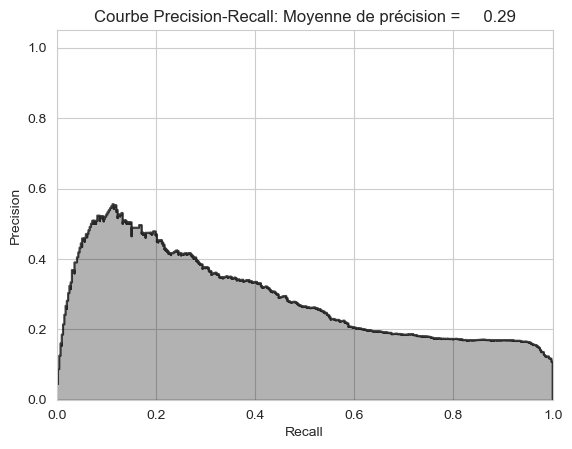

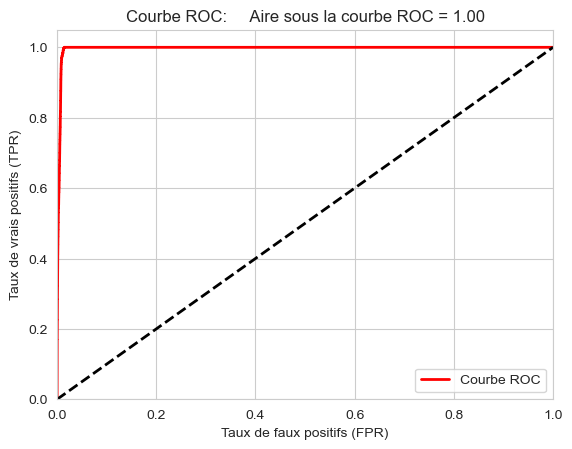

In [40]:
preds = plotResults(y_train, anomalyScores)

Avec une précision moyenne de 0,11, il s'agit d'une mauvaise solution de détection des fraudes (voir
Figure 4-2). Il attrape très peu de fraude.

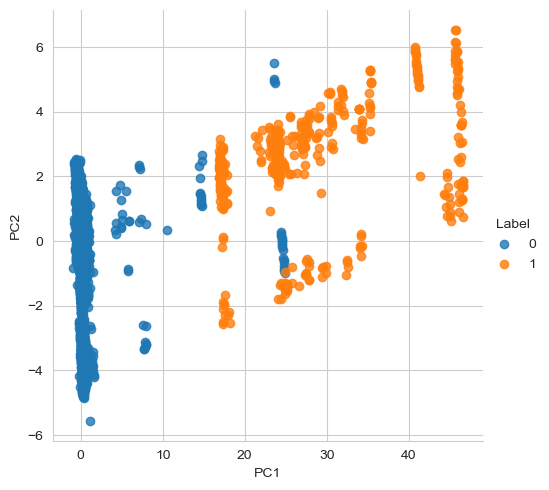

In [41]:
scatterPlot(X_train_pca, y_train)

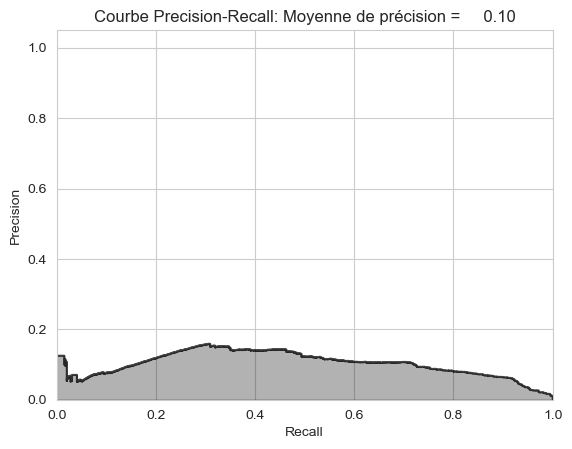

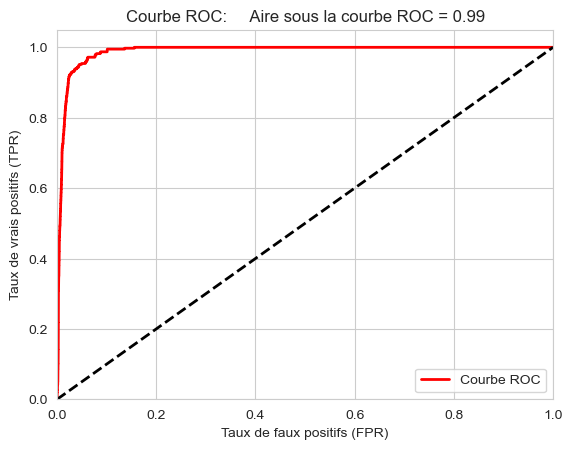

In [42]:
n_components = 10
random_state = 0

pca = PCA(n_components=n_components, random_state=random_state)

X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)

X_train_pca_inverse = pca.inverse_transform(X_train_pca)
X_train_pca_inverse = pd.DataFrame(data=X_train_pca_inverse, index=X_train.index)
anomalyScores = anomaly_scores(X_train, X_train_pca_inverse)
preds = plotResults(y_train, anomalyScores)

En utilisant l'analyse en composantes principales (ACP), nous avons réussi à compresser les données de 30 variables à 10 variables et avons calculé le score de reconstruction. L'histogramme de ce score est présenté ci-dessous

## 3. Composantes PCA 

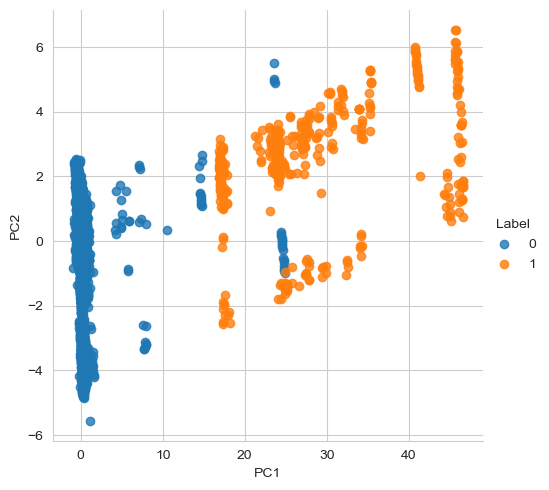

In [43]:
n_components = 20
random_state = 0

pca = PCA(n_components=n_components, random_state=random_state)

X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)

X_train_pca_inverse = pca.inverse_transform(X_train_pca)
X_train_pca_inverse = pd.DataFrame(data=X_train_pca_inverse, index=X_train.index)

scatterPlot(X_train_pca, y_train)

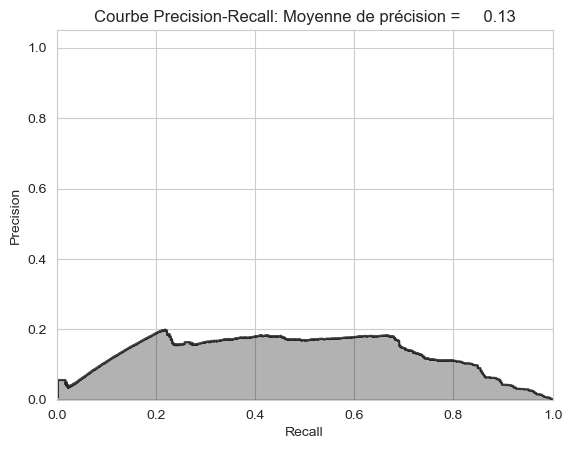

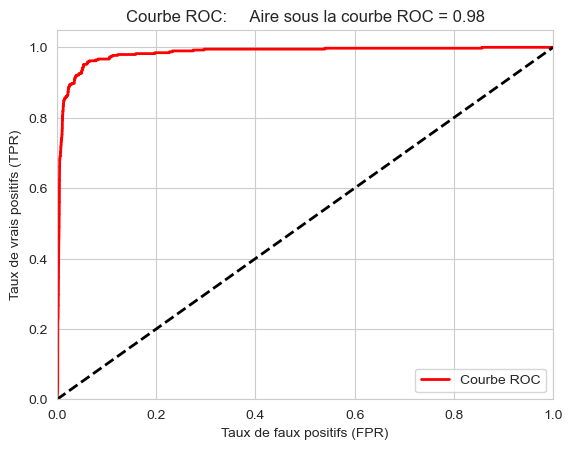

In [44]:
anomalyScores = anomaly_scores(X_train, X_train_pca_inverse)
preds = plotResults(y_train, anomalyScores, True)

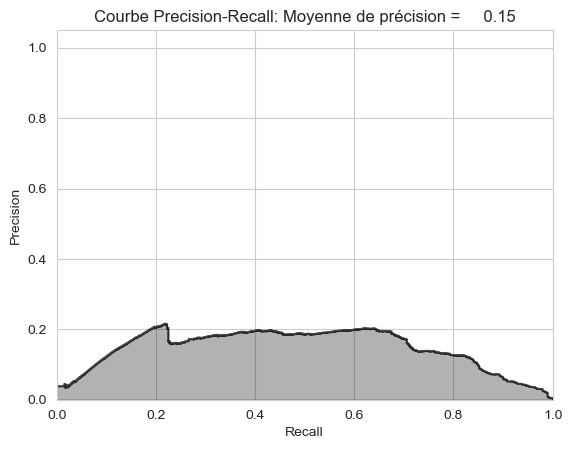

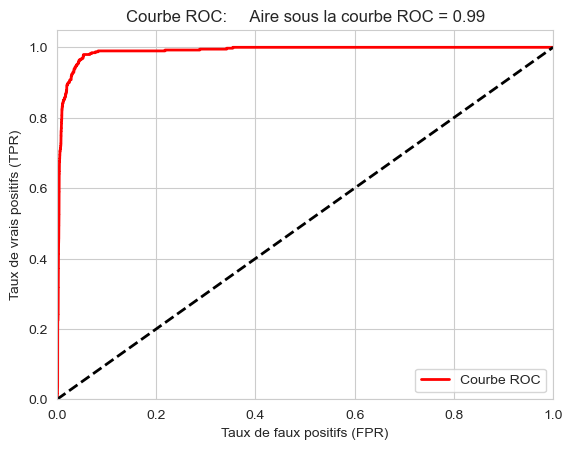

In [45]:
n_components = 25
random_state = 0

pca = PCA(n_components=n_components, random_state=random_state)

X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)

X_train_pca_inverse = pca.inverse_transform(X_train_pca)
X_train_pca_inverse = pd.DataFrame(data=X_train_pca_inverse, index=X_train.index)

anomalyScores = anomaly_scores(X_train, X_train_pca_inverse)
preds = plotResults(y_train, anomalyScores, True)


In [46]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 25
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = 0
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)

kernelPCA.fit(X_train.iloc[:2000])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train.index)

# scatterPlot(X_train_kernelPCA, y_train)

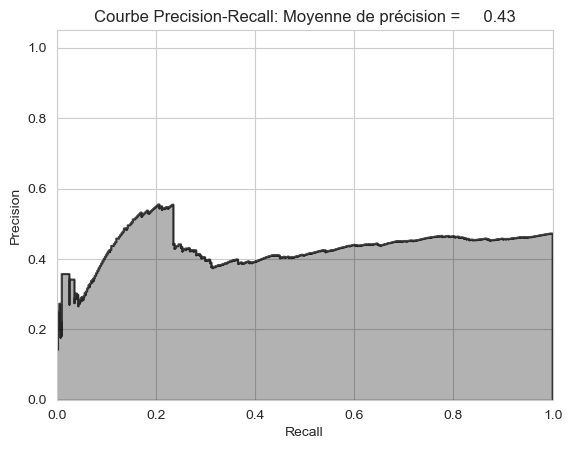

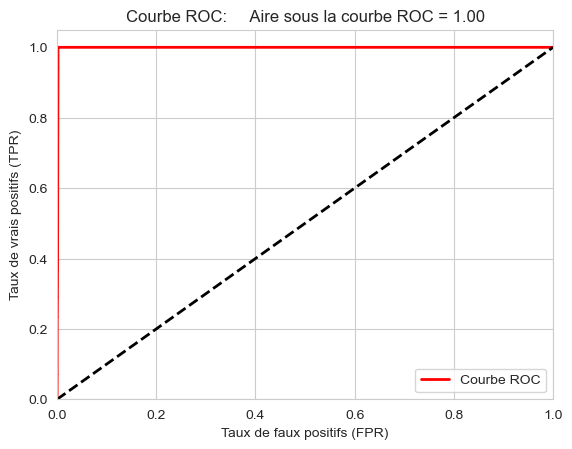

In [47]:
anomalyScoresKernelPCA = anomaly_scores(X_train, X_train_kernelPCA_inverse)
df_preds = plotResults(y_train, anomalyScoresKernelPCA, True)

In [48]:
df_preds.shape

(227845, 2)

## 4. Meilleur modèle de PCA


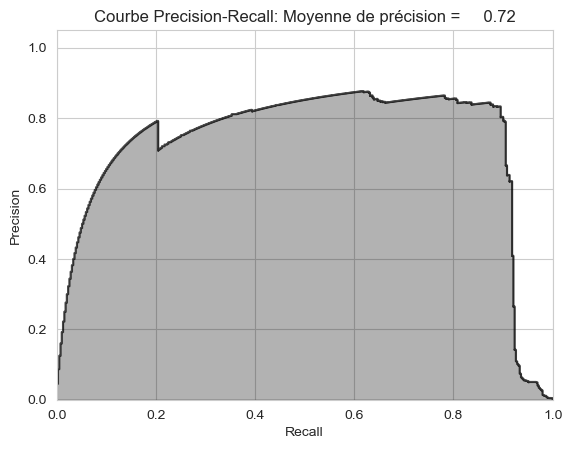

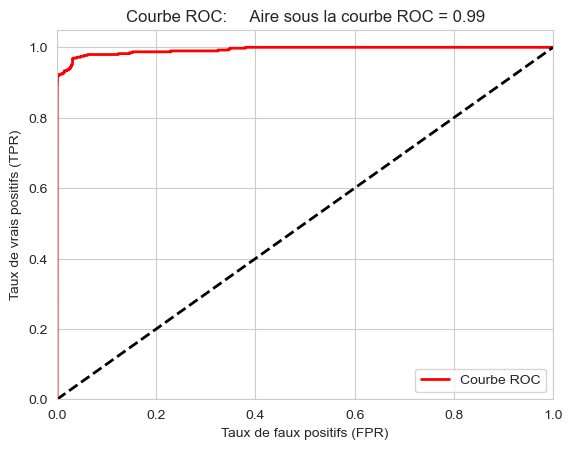

In [49]:
n_components = 28
random_state = 0

pca = PCA(n_components=n_components, random_state=random_state)

X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(data=X_train_pca, index=X_train.index)

X_train_pca_inverse = pca.inverse_transform(X_train_pca)
X_train_pca_inverse = pd.DataFrame(data=X_train_pca_inverse, index=X_train.index)
anomalyScores = anomaly_scores(X_train, X_train_pca_inverse)
preds = plotResults(y_train, anomalyScores, True)

In [50]:
df_preds.head()

,Labels,AnomalyScores
68806,0,0.004026
40018,0,0.000011
250360,0,0.000282
234820,0,0.000016
10001,0,0.000907


In [51]:
df_preds.sort_values(by="AnomalyScores",ascending=False,inplace=True)
cutoff = 391
predsTop = df_preds[:cutoff]
print("Precision: ",np.round(predsTop.AnomalyScores[predsTop.Labels==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop.AnomalyScores[predsTop.Labels==1].count()/y_train.sum(),2))
print("Fraud Caught out of 391 Cases:", predsTop.Labels.sum())

Precision:  0.39
Recall:  0.39
Fraud Caught out of 391 Cases: 152


In [52]:
from sklearn.utils import resample
fraud_indices = y_train[y_train==1].index
non_fraud_indices = resample(y_train[y_train==0],n_samples=2000,random_state=0).index
sample_indices = fraud_indices.append(non_fraud_indices)
sample_indices

Index([119781,  96341,   6774,  58761, 176049,   6609, 153835, 141258,   9035,
       150715,
       ...
       169365,  56730,  71961, 265296, 140757,  81427, 189426, 249813,  98699,
       132952],
      dtype='int64', length=2391)

# Évaluation sur le test set 

In [53]:
X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame(data=X_test_pca, index=X_test.index)

X_test_pca_inverse = pca.inverse_transform(X_test_pca)
X_test_pca_inverse = pd.DataFrame(data=X_test_pca_inverse, \
                                  index=X_test.index)


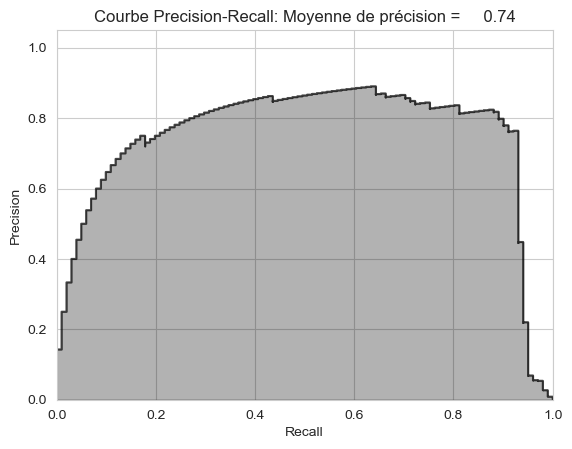

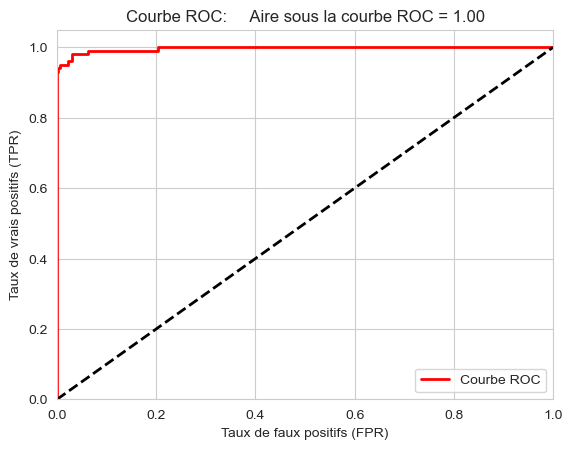

In [54]:
anomalyScoresPCA = anomaly_scores(X_test, X_test_pca_inverse)
df_preds = plotResults(y_test, anomalyScoresPCA, True)

# Autres méthodes

In [55]:
scores = []
for n in range(2, 31):
    pca = PCA(n_components=n)
    pca.fit(X_train)
    X_train_pca = pca.fit_transform(X_train)
    X_train_pca_inverse = pca.inverse_transform(X_train_pca)
    
    scores.append(mean_squared_error(X_train, X_train_pca_inverse))
scores = np.array(scores)
print(scores.argmin() + 2)

30


In [56]:
n_components = 28
pca = PCA(n_components=n_components)

In [57]:
X_train_pca = pca.fit_transform(X_train)
X_train_pca_inverse = pca.inverse_transform(X_train_pca)

X_train_pca_inverse = pd.DataFrame(X_train_pca_inverse, columns=X_train.columns, index=X_train.index)

reconstruction_score = []

for idx in X_train.index:
    score = mean_squared_error(X_train.loc[idx], X_train_pca_inverse.loc[idx])
    reconstruction_score.append(score)
    
rc_scores = pd.DataFrame(reconstruction_score, index=X_train.index, columns=['reconstruction_score'])

rec_mean = rc_scores['reconstruction_score'].mean()
rec_median = rc_scores['reconstruction_score'].median()
rec_std = rc_scores['reconstruction_score'].std()

rc_scores = rc_scores.sort_values(by='reconstruction_score', ascending=False)

top_scores_idx = rc_scores[(rc_scores > (rec_median + 2*rec_std))].dropna().index
train_fraud_index = list(y_train[y_train == 1].index)

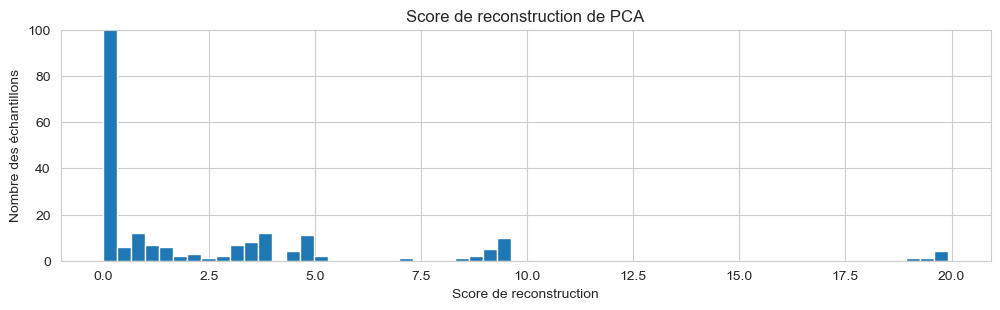

In [72]:
plt.figure(figsize=(12, 3))
rc_scores['reconstruction_score'].hist(bins=60)
plt.ylim(0, 100)
plt.title('Score de reconstruction de PCA')
plt.xlabel('Score de reconstruction')
plt.ylabel('Nombre des échantillons')
plt.show()

In [59]:
pred = pd.DataFrame(index=X_train.index)
pred['fraud'] = 0
for x in top_scores_idx:
    pred['fraud'].loc[x] = 1

print(classification_report(y_train, pred['fraud']))
print('Rate of transations to investigate:', len(top_scores_idx) / len(X_train) * 100, '%')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227454
           1       0.84      0.84      0.84       391

    accuracy                           1.00    227845
   macro avg       0.92      0.92      0.92    227845
weighted avg       1.00      1.00      1.00    227845

Rate of transations to investigate: 0.1720467861923676 %


In [60]:
X_test_pca = pca.fit_transform(X_test)
X_test_pca_inverse = pca.inverse_transform(X_test_pca)

X_test_pca_inverse = pd.DataFrame(X_test_pca_inverse, columns=X_test.columns, index=X_test.index)

reconstruction_score = []
for idx in X_test.index:
    score = mean_squared_error(X_test.loc[idx], X_test_pca_inverse.loc[idx])
    reconstruction_score.append(score)
    
rc_scores = pd.DataFrame(reconstruction_score, index=X_test.index, columns=['reconstruction_score'])

rec_mean = rc_scores['reconstruction_score'].mean()
rec_median = rc_scores['reconstruction_score'].median()
rec_std = rc_scores['reconstruction_score'].std()

rc_scores = rc_scores.sort_values(by='reconstruction_score', ascending=False)

top_scores_idx = rc_scores[(rc_scores > (rec_median + 2*rec_std))].dropna().index
val_fraud_index = list(y_test[y_test == 1].index)

In [61]:
pred = pd.DataFrame(index=X_test.index)
pred['fraud'] = 0
for x in top_scores_idx:
    pred['fraud'].loc[x] = 1
    
print(classification_report(y_test, pred['fraud']))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.83      0.85      0.84       101

    accuracy                           1.00     56962
   macro avg       0.91      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [81]:
X_pca_tsne = pca.fit_transform(X_train)
X_pca_tsne = pd.DataFrame(X_pca_tsne, index=X_train.index)

X_pca_tsne['Class'] = y_train
ok_sample = X_pca_tsne[X_pca_tsne['Class'] == 0]# .sample(2000)
df_fraud = X_pca_tsne[X_pca_tsne['Class'] == 1]
ok_sample.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,Class
68806,0.072039,0.192121,0.132390,-0.224405,-0.741704,-0.401914,-0.457563,3.211791,-0.047455,3.328867,1.522839,-0.906010,0.433944,-0.699964,0.564984,0.256421,-0.001479,1.549581,-1.432353,0.907045,0.479367,-1.216614,0.154990,1.211725,1.850714,2.760031,-0.602123,-0.421151,0
40018,-0.063293,-0.107550,0.020535,-0.350159,-0.028356,-0.460157,-0.012947,-0.372162,-0.182088,0.374531,-0.515609,-0.104315,0.025047,0.255276,-0.602916,1.087117,-0.178146,-0.570917,1.411137,-0.809637,-1.368342,-0.364397,-1.282203,0.287036,0.026011,0.175863,0.156451,0.070620,0
250360,-0.149976,0.768377,0.234959,-0.113339,-0.050696,-0.306878,-0.387389,1.021905,-0.300214,-1.234323,0.344590,0.270074,1.445648,-1.148708,0.765672,-1.719280,1.614888,-0.686177,-1.227935,-0.418801,1.125250,0.082374,-0.837638,1.647832,-0.180861,0.111866,0.001341,-0.101161,0
234820,-0.019729,0.498734,-0.465084,0.065709,-0.308573,-0.082699,-0.124622,-0.207962,0.102142,-0.176482,-0.161150,1.778686,0.246497,0.018669,-0.719307,-0.202043,-0.733205,-0.049751,-1.118688,1.207696,-0.761567,-0.227965,0.142140,0.133031,0.528929,0.163803,-0.061041,0.047087,0
10001,0.315665,-3.748439,-0.490063,-0.609658,0.507996,0.382747,-0.568968,0.582524,0.592431,0.206715,0.810238,-0.561669,1.228097,-0.433311,1.045351,0.006976,-0.488072,-0.069865,1.596392,-0.437718,1.421417,1.702229,-1.485998,-0.530221,0.160545,-0.494888,-0.421576,-0.315661,0


In [82]:
ok_sample.shape

(227454, 29)

In [83]:
df_fraud.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,Class
119781,31.793810,4.209474,-0.906894,0.760964,-2.888620,2.310938,-1.928594,-0.388978,-0.566836,-0.246441,-0.388246,-2.757844,-0.694938,1.479346,1.273228,1.078516,2.095299,-2.523452,-2.112990,-4.072651,1.034544,1.479026,0.257203,1.408512,2.686354,1.585324,1.074687,0.490696,1
96341,16.987226,2.238866,-0.396765,0.450182,-0.399697,-0.422534,0.541188,0.238596,-0.542783,0.386674,-0.710854,0.917136,-1.641740,-1.746940,-0.079659,-0.828462,-0.949213,-0.789297,0.916113,-0.131069,0.946126,-0.403925,-1.223431,-0.181906,0.048763,0.063475,-0.052496,0.222341,1
6774,29.429148,-0.843130,-1.403319,0.824144,-2.730681,1.340421,-0.528380,1.959179,-0.464972,0.813315,0.498577,2.974344,0.290920,1.368299,-0.091471,1.538280,-0.502755,-2.875859,1.582638,-1.849095,0.672849,1.156767,-0.013392,1.214536,0.810850,-0.880930,-0.604824,0.026924,1
58761,17.090131,1.754756,-0.601464,0.349857,-0.885509,0.142678,0.552999,0.923562,0.540879,-1.005805,0.128430,0.688817,-0.401735,-0.223493,-0.063139,-1.076047,-2.287507,-0.415759,-0.959683,1.362317,-1.146663,-0.736053,-0.808325,0.323320,-0.108054,0.062886,-0.021338,0.297669,1
176049,17.078347,1.057031,0.086510,6.340673,3.121189,0.564620,-1.857438,-0.097405,-1.262538,-0.425089,-0.275772,1.124577,0.471003,2.851002,0.855160,-1.283368,-0.031194,0.426836,-0.149655,1.052836,2.175321,-1.374239,0.291281,1.910557,-1.085640,3.368480,0.455762,0.003646,1


In [84]:
df_fraud.shape

(391, 29)

In [85]:
df_tsne = pd.concat([ok_sample, df_fraud])

In [86]:
df_tsne.shape

(227845, 29)

In [87]:
X_tsne = df_tsne.values
y_tsne = df_tsne["Class"].values

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_tsne)

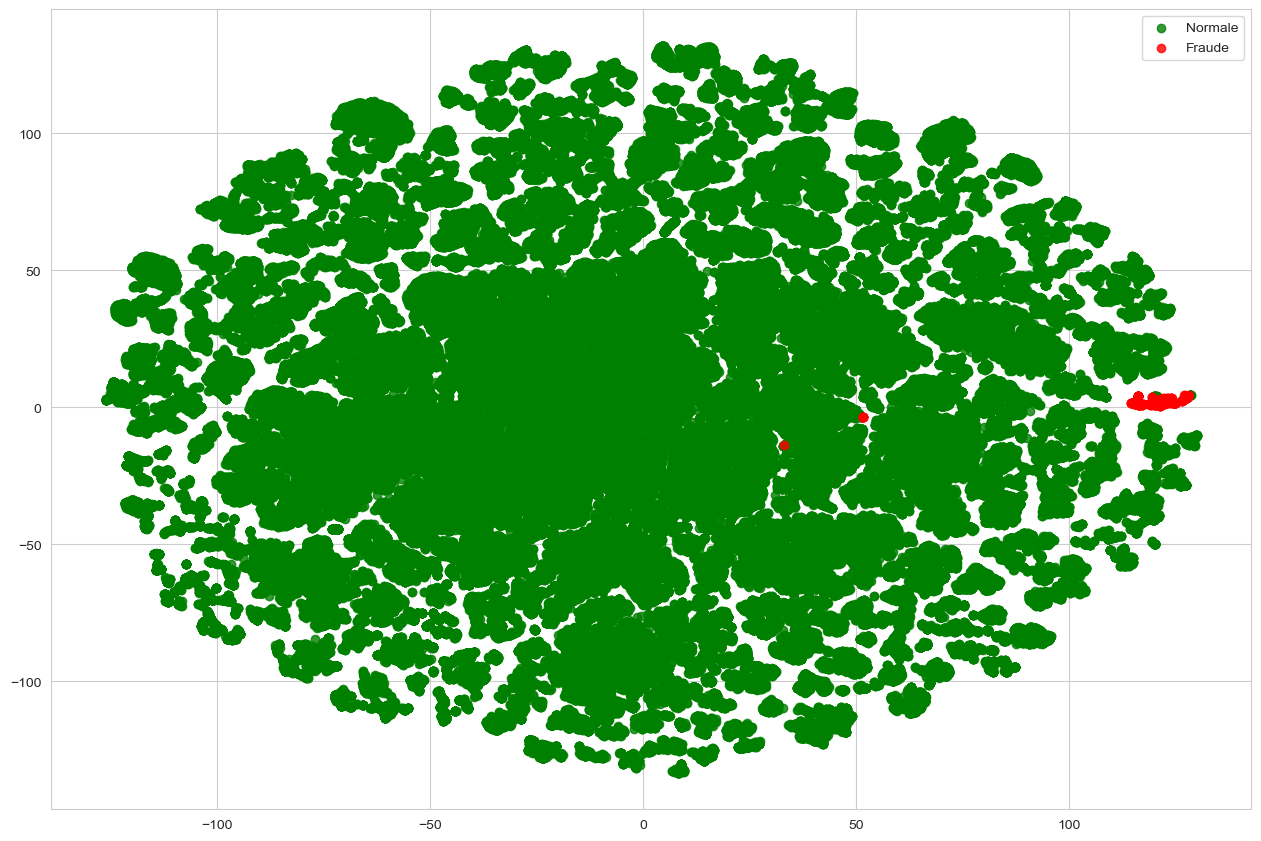

In [88]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])

ax.scatter(X_tsne[np.where(y_tsne == 0), 0], X_tsne[np.where(y_tsne == 0), 1],
           marker='o', color='g', linewidth=1, alpha=0.8, label='Normale')
ax.scatter(X_tsne[np.where(y_tsne == 1), 0], X_tsne[np.where(y_tsne == 1), 1],
           marker='o', color='r', linewidth=1, alpha=0.8, label='Fraude')
ax.legend(loc='best')

In [89]:
# test set 
X_pca_tsne_test = pca.fit_transform(X_test)
X_pca_tsne_test = pd.DataFrame(X_pca_tsne_test, index=X_test.index)

X_pca_tsne_test['Class'] = y_test
ok_sample_test = X_pca_tsne_test[X_pca_tsne_test['Class'] == 0]#.sample(2000)
df_fraud_test = X_pca_tsne_test[X_pca_tsne_test['Class'] == 1]

In [90]:

df_tsne_test = pd.concat([ok_sample_test, df_fraud_test])

# ok_sample.append(df_fraud).sample(frac=1).reset_index(drop=True)

X_tsne_test = df_tsne_test.values
y_tsne_test = df_tsne_test["Class"].values

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne_test = tsne.fit_transform(X_tsne_test)

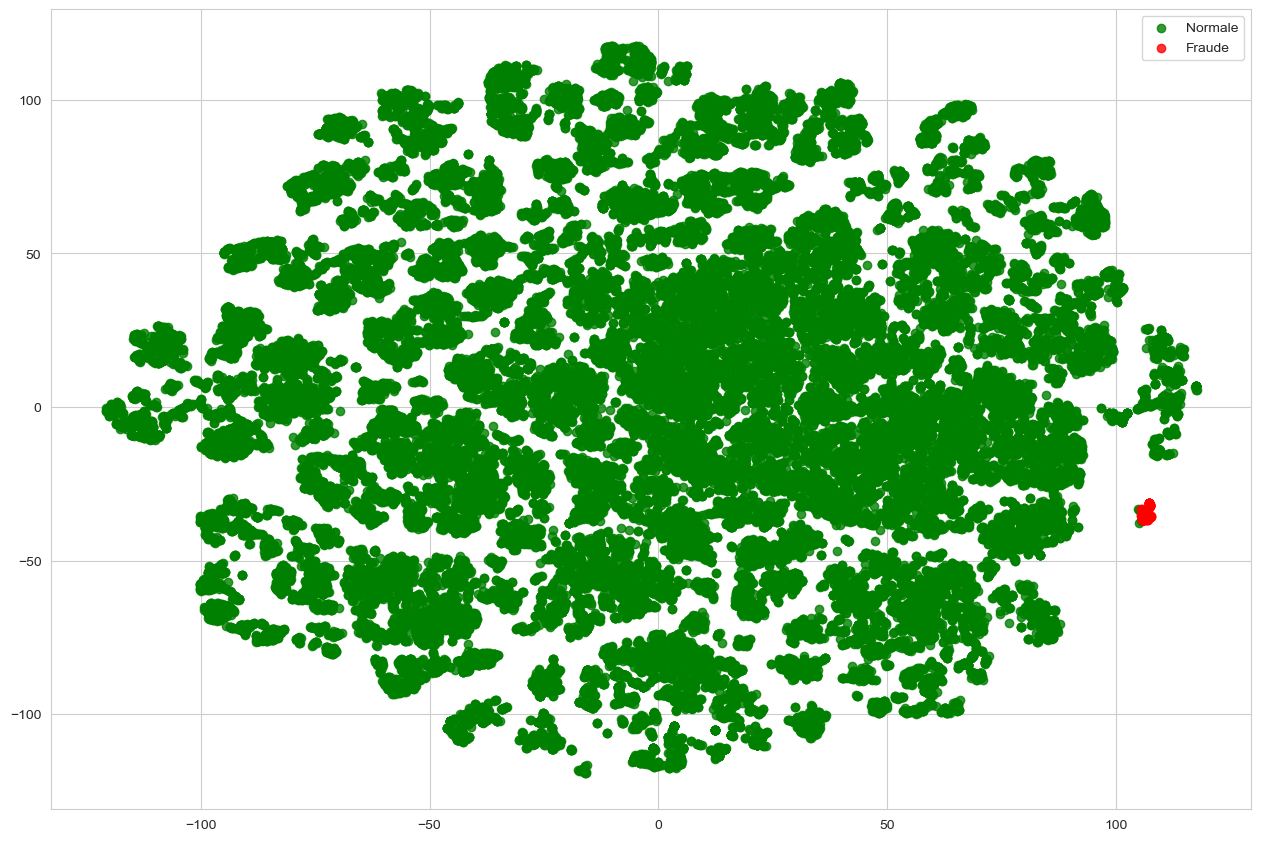

In [91]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0, 0, 1, 1])

ax.scatter(X_tsne_test[np.where(y_tsne_test == 0), 0], X_tsne_test[np.where(y_tsne_test == 0), 1],
           marker='o', color='g', linewidth=1, alpha=0.8, label='Normale')
ax.scatter(X_tsne_test[np.where(y_tsne_test == 1), 0], X_tsne_test[np.where(y_tsne_test == 1), 1],
           marker='o', color='r', linewidth=1, alpha=0.8, label='Fraude')
ax.legend(loc='best')